# Basic Events Analysis

## Trigger

In [4]:
from obspy.core import read
st = read("https://examples.obspy.org/ev0_6.a01.gse2")
st = st.select(component="Z")
tr = st[0]

In [5]:
print(tr.stats)

         network: 
         station: EV0_6
        location: 
         channel: EHZ
       starttime: 1970-01-01T01:00:00.000000Z
         endtime: 1970-01-01T01:00:59.995000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 12000
           calib: 1.0
         _format: GSE2
            gse2: AttribDict({'auxid': '', 'datatype': 'CM6', 'calper': 1.0, 'instype': '', 'hang': 0.0, 'vang': -1.0})


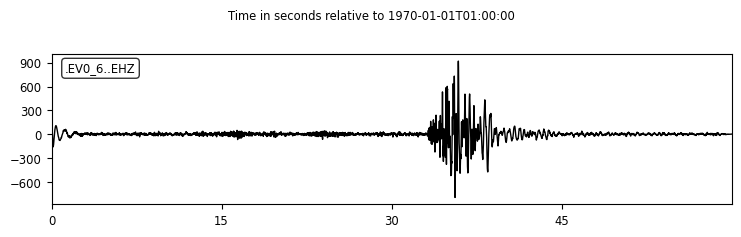

In [7]:
trace_relative = tr.plot(type="relative")

In [8]:
from obspy.signal.trigger import classic_sta_lta
help(classic_sta_lta)  

Help on function classic_sta_lta in module obspy.signal.trigger:

classic_sta_lta(a, nsta, nlta)
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples.
    
    Fast version written in C.
    
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of classic STA/LTA



The commands to read in the data and to load the modules are the following:



In [9]:
from obspy.core import read
from obspy.signal.trigger import plot_trigger
trace = read("https://examples.obspy.org/ev0_6.a01.gse2")[0]
df = trace.stats.sampling_rate

Classic Sta Lta:

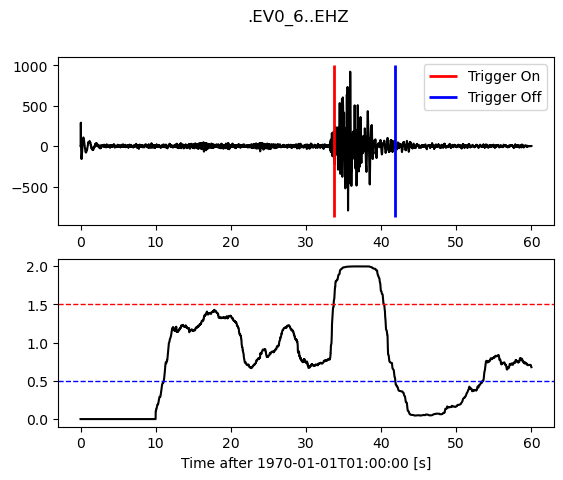

In [10]:
from obspy.signal.trigger import classic_sta_lta
cft = classic_sta_lta(trace.data, int(5 * df), int(10 * df))
plot_trigger(trace, cft, 1.5, 0.5)

Z-Detect:

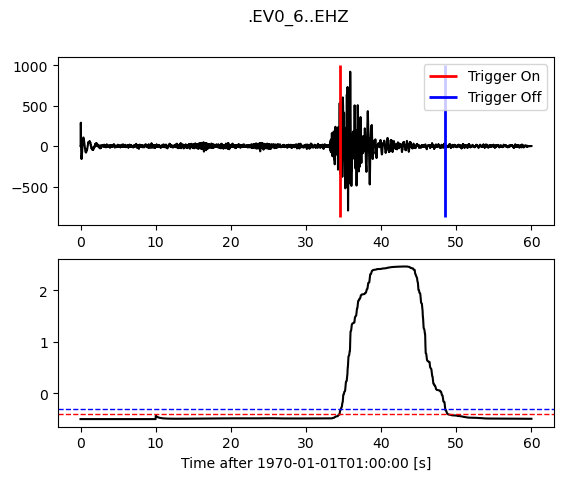

In [12]:
from obspy.signal.trigger import z_detect
cft = z_detect(trace.data, int(10 * df))
plot_trigger(trace, cft, -0.4, -0.3)

Recursive Sta Lta:

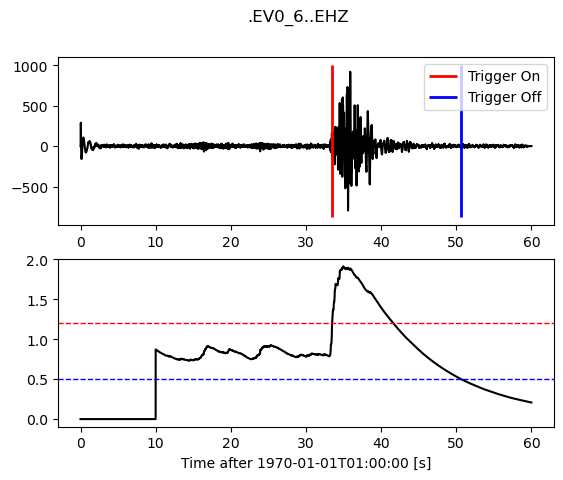

In [13]:
from obspy.signal.trigger import recursive_sta_lta
cft = recursive_sta_lta(trace.data, int(5 * df), int(10 * df))
plot_trigger(trace, cft, 1.2, 0.5)

Carl-Sta-Trig:

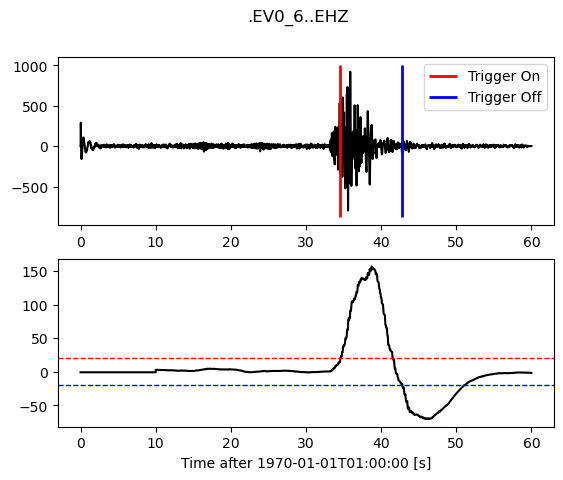

In [14]:
from obspy.signal.trigger import carl_sta_trig
cft = carl_sta_trig(trace.data, int(5 * df), int(10 * df), 0.8, 0.8)
plot_trigger(trace, cft, 20.0, -20.0)

Delayed Sta Lta:

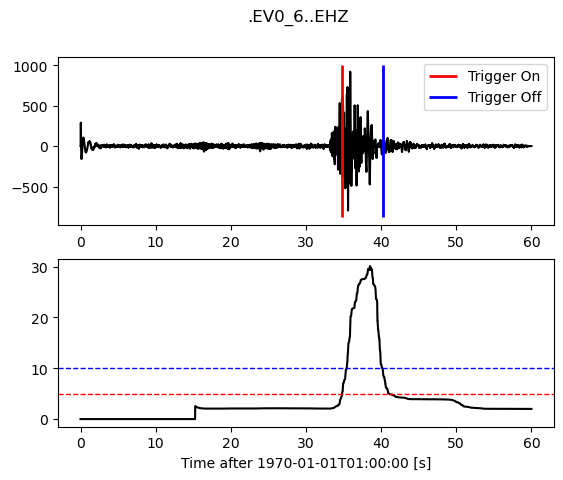

In [15]:
from obspy.signal.trigger import delayed_sta_lta
cft = delayed_sta_lta(trace.data, int(5 * df), int(10 * df))
plot_trigger(trace, cft, 5, 10)

## Picker

Baer Picker:

In [16]:
from obspy.core import read
from obspy.signal.trigger import pk_baer
trace = read("https://examples.obspy.org/ev0_6.a01.gse2")[0]
df = trace.stats.sampling_rate
p_pick, phase_info = pk_baer(trace.data, df,
                            20, 60, 7.0, 12.0, 100, 100)
print(p_pick)

print(phase_info)

print(p_pick / df)

6894
EPU3
34.47


AR Picker:

In [17]:
from obspy.core import read
from obspy.signal.trigger import ar_pick
tr1 = read('https://examples.obspy.org/loc_RJOB20050801145719850.z.gse2')[0]
tr2 = read('https://examples.obspy.org/loc_RJOB20050801145719850.n.gse2')[0]
tr3 = read('https://examples.obspy.org/loc_RJOB20050801145719850.e.gse2')[0]
df = tr1.stats.sampling_rate
p_pick, s_pick = ar_pick(tr1.data, tr2.data, tr3.data, df,
                         1.0, 20.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
print(p_pick)
print(s_pick)

d:\Anaconda\envs\obspy\lib\site-packages\obspy\io\gse2\libgse2.py:319: UserWarning: Checksum differs only in absolute value. If this file was written with ObsPy GSE2, this is due to a bug in the obspy.io.gse2.write routine (resolved with [3431]), and thus this message can be safely ignored.
  warnings.warn(msg, UserWarning)


30.635000228881836
31.165000915527344


AIC - Akaike Information Criterion by Maeda (1985):

In [19]:
from obspy.core import read, UTCDateTime
from obspy.signal.trigger import aic_simple
trace = read("https://examples.obspy.org/ev0_6.a01.gse2")[0]
df = trace.stats.sampling_rate
trace_s = trace.slice(UTCDateTime('1970-01-01T01:00:31.6'),
                      UTCDateTime('1970-01-01T01:00:34.3'))
aic_f = aic_simple(trace_s.data)
p_idx = aic_f.argmin()
print(p_idx / df)
print(UTCDateTime('1970-01-01T01:00:31.6') + (p_idx / df))

1.62
1970-01-01T01:00:33.220000Z


Complex example:

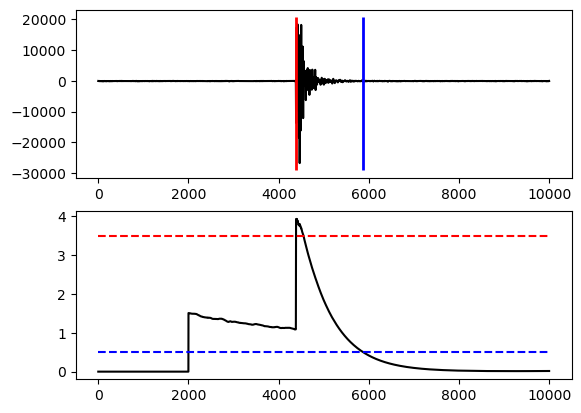

In [18]:
import matplotlib.pyplot as plt

import obspy
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta, trigger_onset


# Retrieve waveforms via FDSNWS
client = Client("LMU")
t = obspy.UTCDateTime("2009-08-24 00:19:45")
st = client.get_waveforms('BW', 'RTSH', '', 'EHZ', t, t + 50)

# For convenience
tr = st[0]  # only one trace in mseed volume
df = tr.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr.data, int(2.5 * df), int(10. * df))
on_of = trigger_onset(cft, 3.5, 0.5)

# Plotting the results
ax = plt.subplot(211)
plt.plot(tr.data, 'k')
ymin, ymax = ax.get_ylim()
plt.vlines(on_of[:, 0], ymin, ymax, color='r', linewidth=2)
plt.vlines(on_of[:, 1], ymin, ymax, color='b', linewidth=2)
plt.subplot(212, sharex=ax)
plt.plot(cft, 'k')
plt.hlines([3.5, 0.5], 0, len(cft), color=['r', 'b'], linestyle='--')
plt.axis('tight')
plt.show()

## Export Seismograms

In [21]:
from obspy.core import read
stream = read('https://examples.obspy.org/RJOB20090824.ehz')
stream.write('outfile.ascii', format='SLIST')